# Plenoptic-Toolbox To D-NeRF dataset format


#### Notes on D-NeRF dataset:

In the nerfstudio DNeRF parser, `camera_angle_x` parameter (found in the transforms files) has a $1/2*tanh(0.5*x)$ relationship with the focal length. As the PTB dataset does not come with this, I use the nerfstudio repository to perform camera calibration using the 0th frame of all the videos. This will give us `(f_x, f_y, c_x, c_y)` (the focal and pixel area intrinsics) which replace the `camera__angle_x` parametr present in the initial D-NeRF dataset

Otherwise the `rotation` parameter found for each frame doesn't seem to have any impact on performance - at least in the tests I ran with K-Planes.

---
# Configuration
---

1. Set-Up directories
2. Filter through the PTB dataset and re-construct the transformation matrix.
3. Store training data
4. Repeat for Test and Val data

In [10]:
import os

# Set the plenoptic toolbox (ptb) config and video files
config_fp ='data/plenoptic_toolbox/161029_sports1/calibration_161029_sports1.json'
compare_config_fp ='data/luca_DN/transforms_train.json'
video_fp = 'data/plenoptic_toolbox/161029_sports1/hdVideos/'
# Assert input data exists
assert os.path.exists(config_fp), AssertionError(f'Config Non-Existent : {config_fp}')
assert os.path.exists(video_fp), AssertionError(f'Config Non-Existent : {video_fp}')
assert os.path.exists(compare_config_fp), AssertionError(f'Config Non-Existent : {compare_config_fp}')

# Set the video type
if 'hdVideos' in video_fp:
    camType = 'hd'
elif 'vgaVideos' in video_fp:
    camType = 'vga'
else: # default currently assumes VGA camera dataset
    camType = 'vga'

In [11]:
# Create destination for the  new dataset
output_fp = 'data/plenoptic_toolbox/161029_sports1/dnerf/'
os.makedirs(output_fp, exist_ok=True) # create root folder

train_im_fp = output_fp+'train/'
test_im_fp = output_fp+'test/'
val_im_fp = output_fp+'val/'
os.makedirs(train_im_fp, exist_ok=True) # create train, test and val folders
os.makedirs(test_im_fp, exist_ok=True)
os.makedirs(val_im_fp, exist_ok=True)

In [12]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

with open(config_fp, 'r') as fp:
    config = json.load(fp)

with open(compare_config_fp, 'r') as fp:
    comp_config = json.load(fp)


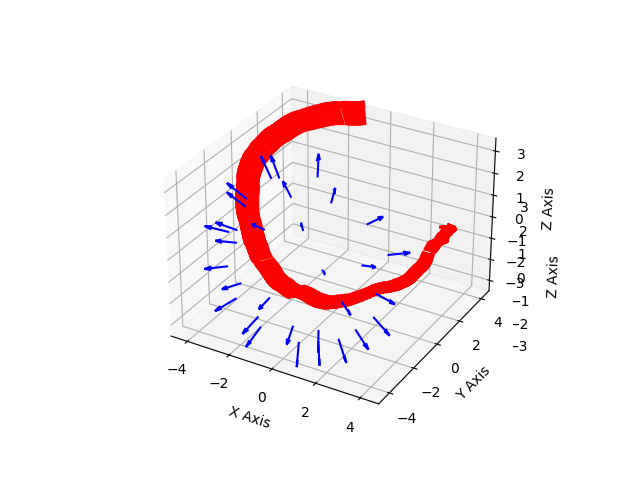

In [13]:
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

# Initialise used_frame dict
used_frames = {} # dict for storing "[camera]":[frame0, frame 12, frame 129, ...] (frames used in train and/or test)

# Filter through camera data and store video pose data
cameras = []
camera_meta = []
for cam in config['cameras']:
    if cam['type'] == 'hd':
        # Construct a 4x4 transformation matrix
        R = np.matrix(cam['R'])
        t = np.array(cam['t'])
        transformation_matrix = np.eye(4)
        transformation_matrix[:3, :3] = -R.transpose()
        cc = (-R.transpose()*t)
        transformation_matrix[:3, 3] =cc.flatten()/80. # Here we re-scale scene from 300x300x300 to 4x4x4 (not exactly 4 but nearly)
        
        uvw = transformation_matrix[:3, 2]
        xyz = transformation_matrix[:3, 3]
        ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=1)

        cameras.append(torch.from_numpy(transformation_matrix))
        camera_meta.append(cam)

for cam in comp_config['frames']:
    transformation_matrix = np.matrix(cam["transform_matrix"])
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='r', length=1)

# Customize the plot as needed
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

#  Rotate Cameras around World Axis Lines

1. Define the angles of rotation
2. Construct the world rotation matrix

In [14]:
def get_Rotation(angx, angy,angz):
                # Convert deg to radians
        angz = angz * np.pi / 180.
        angx = angx * np.pi / 180
        angy = angy * np.pi / 180
        Rz = torch.tensor([[np.cos(angz), -np.sin(angz), 0],
                        [np.sin(angz), np.cos(angz), 0],
                        [0, 0, 1]], dtype=torch.double) # Construct rotation transform
        Rx = torch.tensor([[np.cos(angx), 0, np.sin(angx)],
                        [0, 1, 0.],
                        [-np.sin(angx), 0, np.cos(angx)]
                                ], dtype=torch.double)
        Ry = torch.tensor([[1, 0, 0],
                        [0, np.cos(angy), -np.sin(angy)],
                        [0, np.sin(angy), np.cos(angy)]
                                ], dtype=torch.double)

        # Get world rotation
        R = torch.mm(Ry, Rx)
        R = torch.mm(Rz, R)
        R = torch.cat([R.T, torch.tensor([[0., 0., 0.]], dtype=torch.double)],dim=0).T
        return R

In [15]:
# Set the angles for rotation around axis lines
angx=0
angy=268
angz=0

R = get_Rotation(angx, angy, angz)

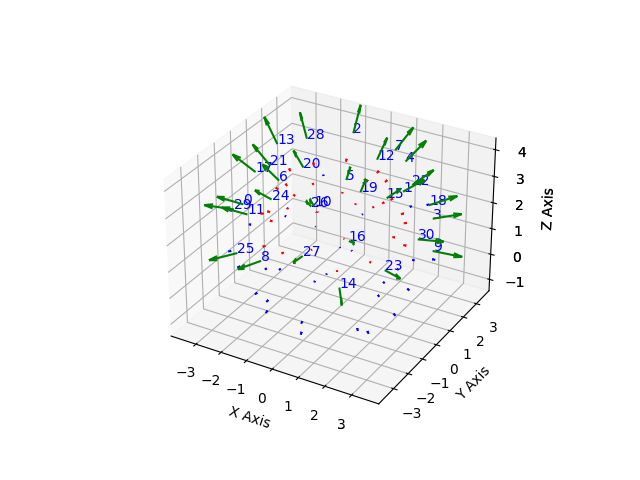

In [16]:
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

# Initialise used_frame dict
used_frames = {} # dict for storing "[camera]":[frame0, frame 12, frame 129, ...] (frames used in train and/or test)

cameras_ = []
# Filter through camera data and store video pose data
for i, cam in enumerate(cameras):
    transformation_matrix = cam
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]

    # ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=1)

    transformation_matrix = torch.matmul(R, transformation_matrix)
    uvw = transformation_matrix[:3, 2]
    xyz = transformation_matrix[:3, 3]
    ax.text(xyz[0], xyz[1], xyz[2], f'{i}', color='b')
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='g', length=1)    

    xyz = xyz-1.*uvw
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='r', length=0.1)    

    xyz = xyz-6.*uvw
    ax.quiver(xyz[0], xyz[1], xyz[2], uvw[0], uvw[1], uvw[2], color='b', length=0.1)    

    cameras_.append(transformation_matrix)
cameras = cameras_
# Customize the plot as needed
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

# Store Re-fromated data as new dataset

For each second of the video lets store 5 frames from 5 cameras. The PTB dataset is structured so cameras neighbouring (e.g. 15 and 16 or 0 and 30) in the stored sequence are not proximal (I believe this is done to support downloading the dataset for people that wish to not use the whole set).

This will hopefully give us 360deg data per frame.

1. Prepare datset
2. Cycle through each video and extract the relevant frames

In [17]:
import cv2
import random

endFrame = 100 # Set the max frame count of the whole video (from 0 to this)

# Keep track of frames which have been used
used_frames = {}
for meta in camera_meta:
    used_frames[meta['name']] = [] # intiliase frames used for a given camera

camera_indices = [i for i in range(len(cameras))]
cam_groups = [[(ci+i)%len(cameras) for i in range(7)] for ci in camera_indices]

# Shuffle the list randomly (maybe not even necessary but just to add spice...)
random.shuffle(cam_groups)


In [18]:
camera_angle_x = 0.1 # YOU NEED TO SET THIS APPROPRIATELY
train_data = {
    "camera_angle_x":camera_angle_x,
    "frames":[]
}
test_data = {
    "camera_angle_x":camera_angle_x,
    "frames":[]
}
val_data = {
    "camera_angle_x":camera_angle_x,
    "frames":[]
}


for frameIdx in range(endFrame):
    camGroup = cam_groups[frameIdx%len(cam_groups)]
    for i, camIdx in enumerate(camGroup):
        # Fetch the final transform matrix and the camera meta data 
        cam, meta = cameras[camIdx], camera_meta[camIdx]
        # Set the camera name
        fp = video_fp+camType+'_'+meta['name']+'.mp4'
        assert os.path.exists(fp), AssertionError(f'Video Not Found: {fp}')

        # Open video file
        video = cv2.VideoCapture(fp)
        # Set and retrieve frame
        video.set(cv2.CAP_PROP_POS_FRAMES, frameIdx)
        _, img = video.read()

        # i [0, 1, 2, 3] = training
        if i < len(camGroup)-2:
            destinationFolder = train_im_fp
            localDestinationFolder = 'train/'
        # i 5 = testing
        elif i < len(camGroup)-1:
            destinationFolder = test_im_fp
            localDestinationFolder = 'test/'
        # i 6 = validation
        else:
            destinationFolder = val_im_fp
            localDestinationFolder = 'val/'
        
        # Save image as PNG
        reName = meta['name'].split('_')[-1]
        destinationFile = f'{destinationFolder}r_{reName}_{frameIdx}.png'
        cv2.imwrite(destinationFile, img)

        # Store frame data        
        localdestinationFile = f'{localDestinationFolder}r_{reName}_{frameIdx}'

        frameData = {
            "file_path":localdestinationFile,
            "time": float(frameIdx/endFrame),
            "transform_matrix":cam.tolist()
        }

        if i < len(camGroup)-2:
            train_data['frames'].append(frameData)
        elif i < len(camGroup)-1:
            test_data['frames'].append(frameData)
        else:
            val_data['frames'].append(frameData)

# Save framedata as json
with open(output_fp+'transforms_train.json','w') as fp:
    json.dump(train_data, fp)
with open(output_fp+'transforms_test.json','w') as fp:
    json.dump(test_data, fp)
with open(output_fp+'transforms_val.json','w') as fp:
    json.dump(val_data, fp)